### **Title : Using Patients Health Statistics to Determine a Patient's Risk of Heart Disease**

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

- Packages containing functions required for the following classification model. This include packages for code required for classification functions and graphing of scatterplots, bargraphs and line graphs to visualize dataset and classfication model.

#### **Introduction**
As of right now, Coronary Artery Disease(CAD) has been identified as the most common heart disease that oftem presents as chest pain due to significant narrowing of the major arteries around the heart. It has now become a wide spread epidemic on a global scale to the extent that it is now considered the foremost cause of premature mortality and loss of life. In low and middle income countries alone CAD accounts for nearly 7 million deaths and 129 million DALYs annually, a unit of measurement that determines how many years of healthy life was loss either by premature mortality or development of long term disability as a result of contracting CAD(Ralapanawa & Sivakanesan, 2021). Though the United States of America has always been considered to be a high income country, even it still struggles with the prevention and treatment of CAD. Estimates inidcate that around 18.2 million American adults already have CAD (U.S. Department of Health and Human Services). Furthermore, the city of Cleveland, OH has officially been identified as the poorest city within the US, reported to have th highest unemployment and poverty rates though little study has been done to quantify the spread of CAD within such low income areas(Campbell, 2020). Taking all of this information into account, it is clear that we need to study CAD among the Cleveland population to determine the health and well being of US citizens living in these low income areas, however it is unrealistic to perform medical biopsies on every citizen to collect this data. Instead we must use other methods such as statistics and modeling to predict if a person has or is at risk of CAD.

**Question: Can a classification statistics model be used to predict whether a patient is at risk of Coronary Artery Disease from the data of a known sample group?**

We use the Cleveland heart disease data (Janosi et al., 1988), which is a comma separated value file showing a collection of health statistics from patients residing within Cleveland of various ages and sex, who have either been classified as healthy or been diagnosed as positive for a heart disease or condition. As CAD is the most common form of heart disease and the narrowing of arteries are predominant symptoms of CAD (Centers for Disease Control and Prevention, 2021) the researchers for this datatset classified patients whose major arteries have narrowed by more than 50% to be positive for CAD and heart disease in general. 

We can then use a classification algorithm model to determine if any incoming patients have or is potentially at risk of heart disease by comparing their vitals and statistics with that of previously examined and diagnosed patients. 

**Hypothesis: We hypothesize that the predictor variables for heart disease risk will be age, cholestrol level and blood pressure, and that patients classified as postive for heart disease risk will be in higher age grouos and have health statistics that show overall higher blood pressure and higher cholestrol levels.**



#### **Methods and Results**


In [3]:
cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
cleveland_data


New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,risk_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


**Table 1:** Initial heart disease dataset before cleaning and wrangling occurs. As the original datframe did not have column names, they have been provided to help provide better clarity for each potential predictor variable.

Included below is the data dictionary created for our specific dataframe using descriptions from the source (UCI Machine Learning Repository)

*age(numerical): age in years*

*sex: sex (1 = male; 0 = female)*
chest_pain: chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic

*rest_bps(numerical): resting blood pressure (in mm Hg on admission to the hospital)*

*cholestrol_level(numerical): serum cholestoral in mg/dl*

*high_fbs?: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)*

*rest_electrographics: resting electrocardiographic results*
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

*max_heartrate(numerical): maximum heart rate achieved by patient under strenuous exercise*

*exercise_induced_angina: exercise induced angina (1 = yes; 0 = no)*

*oldpeak: ST depression induced by exercise relative to rest*

*slope: the slope of the peak exercise ST segment*
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping

*colored_major_vessels: number of major vessels (0-3) colored by flourosopy*

*thal: 3 = normal; 6 = fixed defect; 7 = reversable defect*

*risk_level: diagnosis of heart disease (angiographic disease status)*
-- present (values 1,2,3,4) from absent (value 0)
-> patients with more than 50% narrowing in their major vessels were classified to have a heart disease(present)

- There are 4 numerical variables in the dataset (age, cholestrol level, resting blood pressure, and max heartrate) that can potentially act as our predictor variables for our classification algorithm model predicting risk level. In order to determine which variables to use for our predictors, the variables are visualized as distributions in histograms to observe if an an presence or absence of heart disease risk correlate with higher or lower variable values.

In [4]:
set.seed(1000)

cleveland_clean<-cleveland_data|>
                select(age, rest_bps, max_heartrate, cholestrol_level, risk_level)|>
                mutate(risk_level=case_when(risk_level==0~"Absent",risk_level==1~"Present",
                                         risk_level==2~"Present",risk_level==3~"Present",risk_level==4~"Present")) |>
                mutate(risk_level = as_factor(risk_level))

cleveland_split <- initial_split(cleveland_clean, prop = 0.75, strata = risk_level)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
cleveland_train
cleveland_test

age,rest_bps,max_heartrate,cholestrol_level,risk_level
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,187,250,Absent
56,120,178,236,Absent
57,140,148,192,Absent
⋮,⋮,⋮,⋮,⋮
57,140,123,241,Present
57,130,115,131,Present
57,130,174,236,Present


age,rest_bps,max_heartrate,cholestrol_level,risk_level
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,130,172,204,Absent
62,140,160,268,Present
57,120,163,354,Absent
⋮,⋮,⋮,⋮,⋮
58,125,144,220,Absent
45,110,132,264,Present
68,144,141,193,Present


**Table 2:** Clean, wranglend and split original dataset to Training(75%) and Testing(25%). Training data will be used to design predictive model (classifier) in the following code.

In [5]:
predictor_summary<- cleveland_train |>
                        group_by(risk_level) |>
                        summarize(across(age:cholestrol_level, mean),count = n()) |>
                        rename("Mean Age" = age,
                                "Mean Rest_BPS"=rest_bps,
                               "Mean Maximum Heartrate" = max_heartrate,
                               "Mean Cholestrol Level"=cholestrol_level,
                               "Risk Level" = risk_level,
                                "No of Patients"=count)

predictor_summary

Risk Level,Mean Age,Mean Rest_BPS,Mean Maximum Heartrate,Mean Cholestrol Level,No of Patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Present,56.66346,134.4615,139.9904,248.1346,104
Absent,51.80328,128.4180,159.5328,244.8689,122


**Table 3:** Summary table calculating the number of patients for each risk level and the average values of each potential predictive variable between patients who are and are not classified as at risk of heart disease. As you can see in this summary table, there are a similar number of patients at risk as those who are not. This is significant as the sample group sizes for each class are similar and so the average values will not be skewed due to one classification having a smaller sample and as a result each individual patient's data would have greater influence on average values calculated.

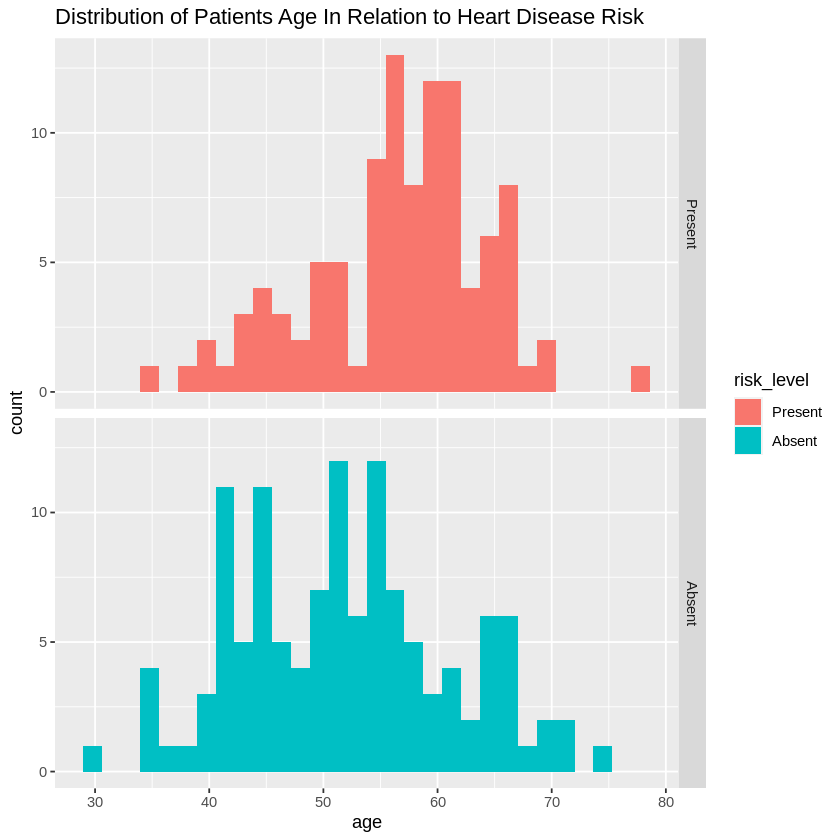

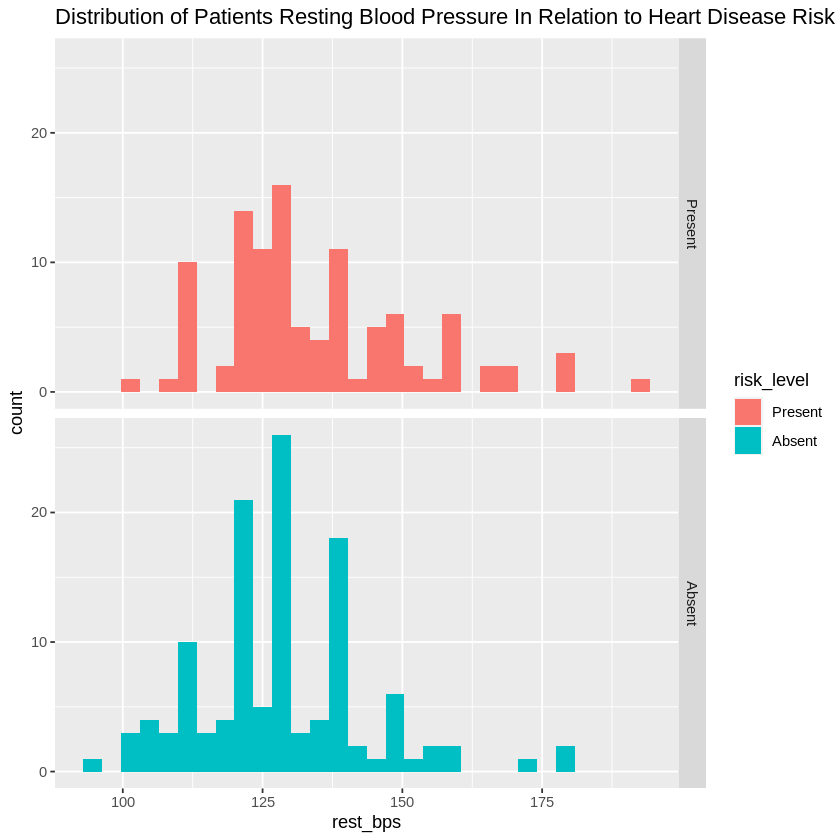

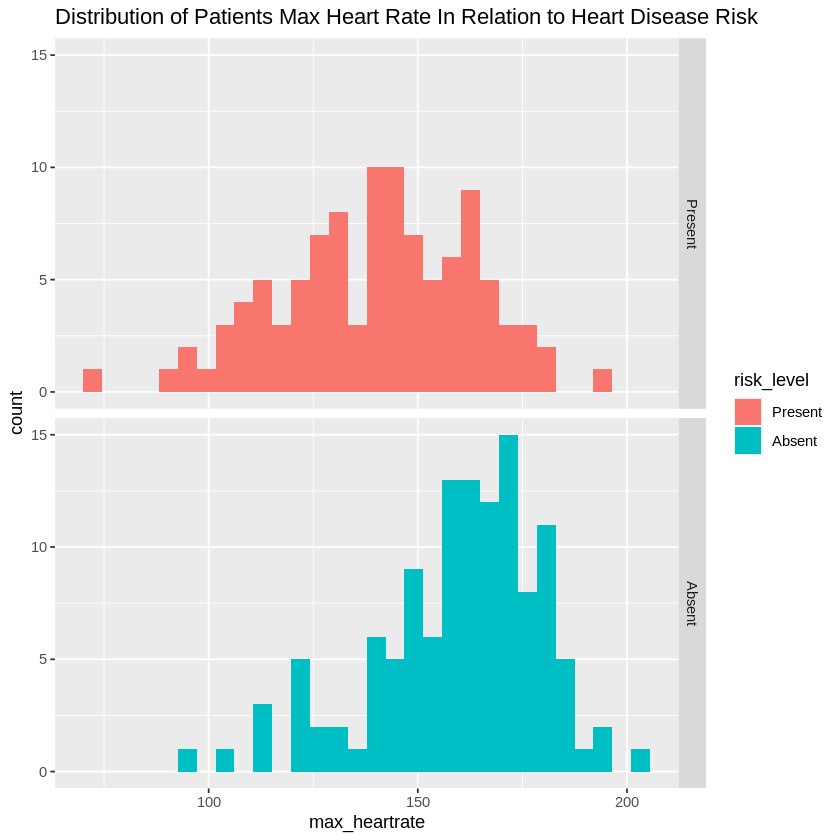

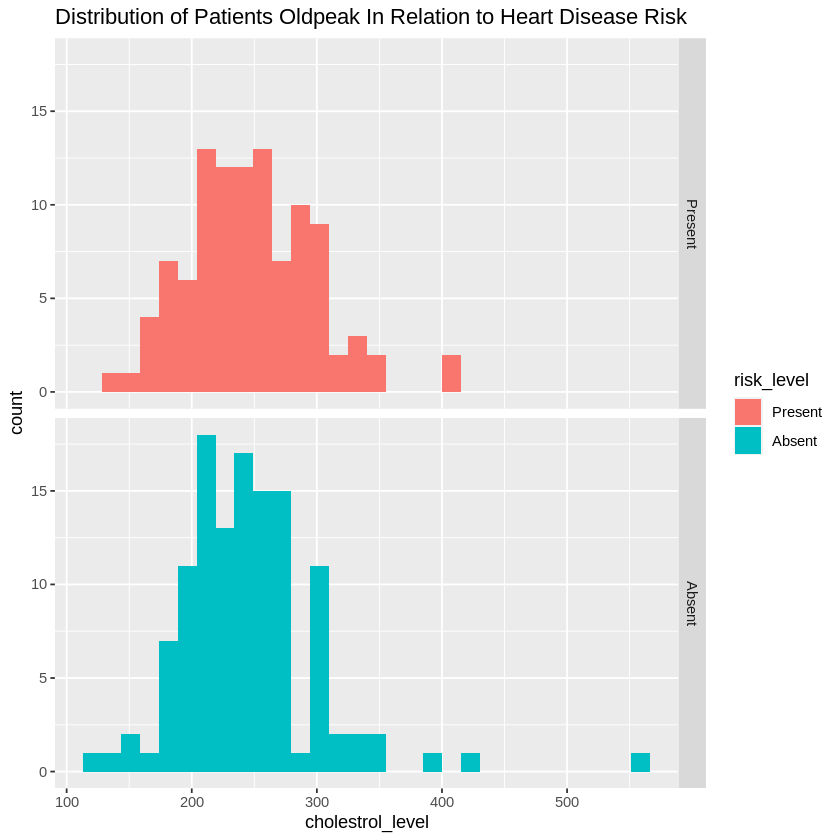

In [6]:
predictor_age <- cleveland_train |>
            ggplot(aes(age, fill = risk_level)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(risk_level))+
            ggtitle("Distribution of Patients Age In Relation to Heart Disease Risk")
predictor_age

predictor_rest_bps<-cleveland_train |>
            ggplot(aes(rest_bps, fill = risk_level)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(risk_level)) +
            ggtitle("Distribution of Patients Resting Blood Pressure In Relation to Heart Disease Risk")
predictor_rest_bps

predictor_max_heartrate<-cleveland_train |>
            ggplot(aes(max_heartrate, fill = risk_level)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(risk_level)) +
            ggtitle("Distribution of Patients Max Heart Rate In Relation to Heart Disease Risk")
predictor_max_heartrate

predictor_oldpeak<-cleveland_train |>
            ggplot(aes(cholestrol_level, fill = risk_level)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(risk_level)) +
            ggtitle("Distribution of Patients Oldpeak In Relation to Heart Disease Risk")
predictor_oldpeak


**Figure 1:** As observed in the visualizations above, while variables oldpeak and rest_bps showed very similar distribution between patients who are and are not at risk of a heart disease, age and max_heartrate showed differences in their distribution. Specifically, a high number of patients who are at risk seem to have a lower max_heart rate and are of higher ages than patients who are classified as not at risk. 

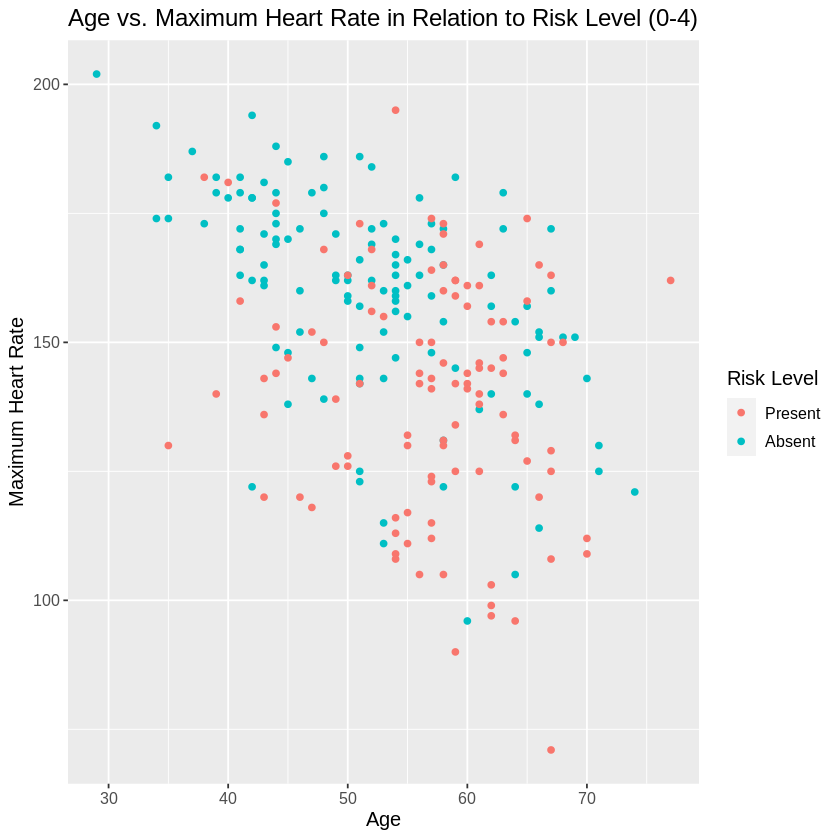

In [7]:
age_heartrate_plot_1 <- cleveland_train |>
                        ggplot(aes(x = age, y = max_heartrate, color=risk_level)) +
                        geom_point() + 
                        xlab("Age") + 
                        ylab("Maximum Heart Rate") +
                        labs(color = "Risk Level") +
                        ggtitle("Age vs. Maximum Heart Rate in Relation to Risk Level (0-4)") +
                        theme(text = element_text(size=12))

age_heartrate_plot_1

**Figure 2:** Scatter plot showing age and maximum heart rate corresponding to risks level. The plot shows that patients with no risks congregrate towards lower age and higher max heart rate, and patients classified as being at risk congregate at higher ages and lower max heart rates. This further supports age and max heart rate as predictor variables for heart disease risk.

- Now that we have established that our predictor variables are Max Heart Rate and Age, we can use these predictor variables to train and code for a classification model to predict the class of any new incoming patient. We must then test the tarining model against the test dataset to determine which k-neighbours value, the number of datapoints closest to the new observation used in its prediction, has the highest probability success rate at predicting the correct class of any new incoming observations.

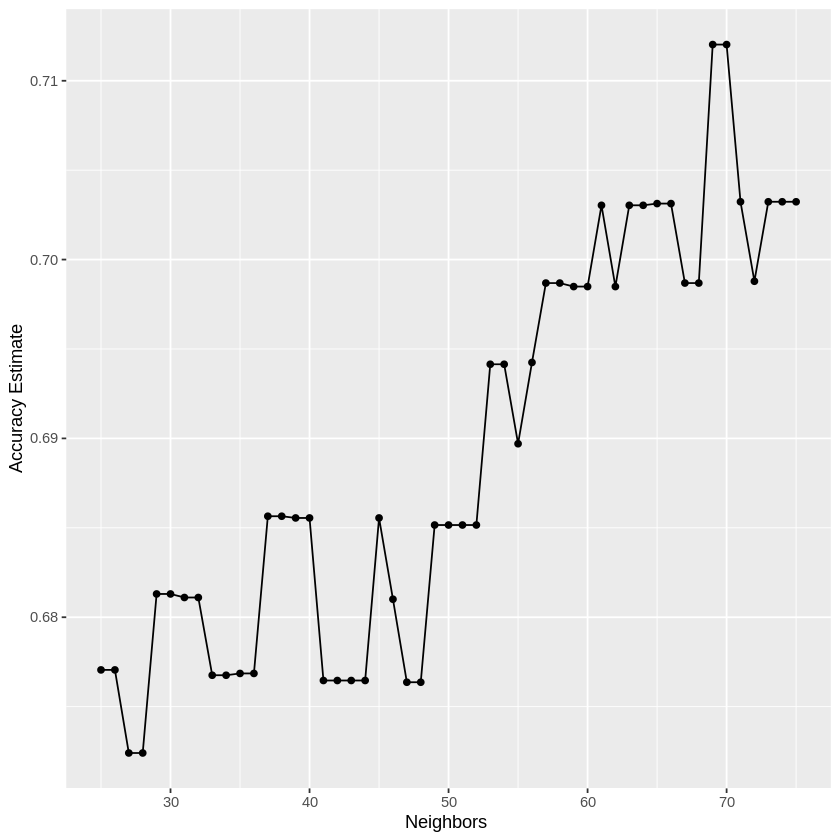

In [8]:
set.seed(2221)
heart_recipe <- recipe(risk_level ~ age+max_heartrate, data = cleveland_train) |>
                step_normalize(all_predictors())

heart_vfold <- vfold_cv(cleveland_train, v = 5, strata = risk_level)

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 25, to = 75, by = 1))

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- heart_fit |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors ", y = "Accuracy Estimate")

cross_val_plot

**Figure 3:** As seen in the Neighbours vs Accuracy Estimate above, using a k-neighbours value of 69, meaning any new observation will be compared with the closest 69 datapoints in the training data and classfied, will provide us with the highest accuracy.

In [9]:
heart_model <- nearest_neighbor(weight_func = "rectangular", neighbor = 69) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_final_fit <- workflow() |>
            add_recipe(heart_recipe) |>
            add_model(heart_model) |>
            fit(data = cleveland_train)

In [10]:
heart_predictions <- heart_final_fit |>
                    predict(cleveland_test) |>
                    bind_cols(cleveland_test)
heart_predictions

heart_accuracy <- heart_predictions |>
                metrics(truth = risk_level, estimate = .pred_class) |>
                filter(.metric == "accuracy") |>
                select(.estimate) |>
                pull()
print(heart_accuracy*100)

heart_predictions_confmat <- heart_predictions |>
                            conf_mat(truth = risk_level, estimate = .pred_class)
heart_predictions_confmat

.pred_class,age,rest_bps,max_heartrate,cholestrol_level,risk_level
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Absent,41,130,172,204,Absent
Present,62,140,160,268,Present
Absent,57,120,163,354,Absent
⋮,⋮,⋮,⋮,⋮,⋮
Present,58,125,144,220,Absent
Present,45,110,132,264,Present
Present,68,144,141,193,Present


[1] 71.05263


          Truth
Prediction Present Absent
   Present      28     15
   Absent        7     26

Accuracy of classifier = 71%

#### **Discussion:**



In [11]:
#proportion for majority classifier

proportions <- cleveland_train |>
group_by(risk_level) |>
summarize(n = n()) |>
mutate(percent = 100*n/nrow(cleveland_train))

proportions

risk_level,n,percent
<fct>,<int>,<dbl>
Present,104,46.0177
Absent,122,53.9823


#### **References:**

Campbell, E. (2020, September 18). Cleveland is now the poorest big city in the country. *The Center for Community Solutions*. Retrieved April 2, 2023, from https://www.communitysolutions.com/cleveland-now-poorest-big-city-country/ 

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. *Centers for Disease Control and Prevention*. Retrieved April 2, 2023, from https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Narrowed%20arteries%20can%20cause%20chest,the%20rest%20of%20your%20body.&amp;text=Over%20time%2C%20CAD%20can%20weaken,blood%20the%20way%20it%20should. 

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). Heart Disease Data Set. *UCI Machine Learning Repository*. Retrieved April 2, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Ralapanawa, U., & Sivakanesan, R. (2021). Epidemiology and the Magnitude of Coronary Artery Disease and Acute Coronary Syndrome: A Narrative Review. *Journal of epidemiology and global health, 11*(2), 169–177. https://doi.org/10.2991/jegh.k.201217.001

U.S. Department of Health and Human Services. What is coronary heart disease? *National Heart Lung and Blood Institute*. Retrieved April 2, 2023, from https://www.nhlbi.nih.gov/health/coronary-heart-disease#:~:text=About%2018.2%20million%20American%20adults,the%20surface%20of%20the%20heart. 